In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38709/status,
Dashboard: /proxy/38709/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38009,Workers: 7
Dashboard: /proxy/38709/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:46735,Total threads: 2
Dashboard: /proxy/34007/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:41519,


In [3]:
start_time, end_time = '1958-01-01', '2018-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
neofs = 3
neigs = 3
npcs = 3

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

def regridder(da_in, label):
    if(label == 'ocean'):     ## Use when there is an atmosphere variable that needs to be converted to ocean grid
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):   ## Use when there is an ocean variable that needs to be converted to atmosphere grid
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

In [6]:
SLP_total = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc')
SLP_total = SLP_total.SLP.sel(time = slice(start_time, end_time))
SLP_total['time'] = SLP_total['time'].values.astype('datetime64[M]') + np.timedelta64(14, 'D')
SLP_total = regridder(SLP_total, 'atmos')
SLP_NA = SLP_total.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
SLP_climatology = SLP_NA.groupby('time.month').mean()

In [7]:
for i in range(61):
    SLP_year = SLP_NA[i*12:i*12+12]
    SLP_year = xr.DataArray(SLP_year, coords = [SLP_climatology.month, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['month', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    SLP_int = SLP_year - SLP_climatology
    SLP_int = xr.DataArray(SLP_int, coords = [SLP_NA[i*12:i*12+12].time, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    if(i==0):
        SLP_int2 = SLP_int
    elif(i!=0):
        SLP_int2 = xr.concat([SLP_int2, SLP_int], dim = 'time')

In [8]:
# Solve for EOF.
coslat = np.cos(np.deg2rad(SLP_NA.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver_SLP = Eof(SLP_int2, weights = wgts)
eof_SLP = solver_SLP.eofsAsCovariance(neofs = neofs)

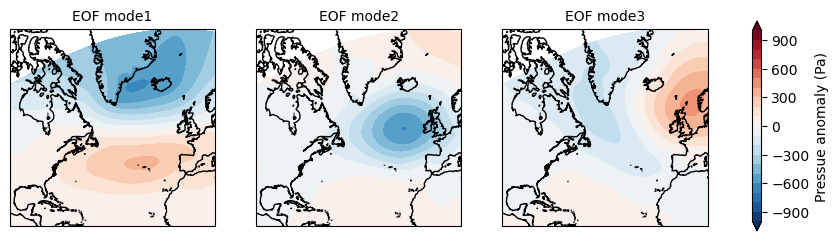

In [9]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[0], levels = np.linspace(-1e3, 1e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[1], levels = np.linspace(-1e3, 1e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[2], levels = np.linspace(-1e3, 1e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/EOF_modes.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

In [10]:
print('Percentage of EOF explained by first ' + str(3) + ' modes:' + str(
    100 * np.round(solver_SLP.varianceFraction(neigs = 3).values, 4)))

Percentage of EOF explained by first 3 modes:[37.56     20.14     12.700001]


In [11]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

In [12]:
pcs_SLP = solver_SLP.pcs(npcs = npcs, pcscaling = 1)
NAO_index_all_months = pcs_SLP.sel(mode = 0).coarsen(time = 12).mean()

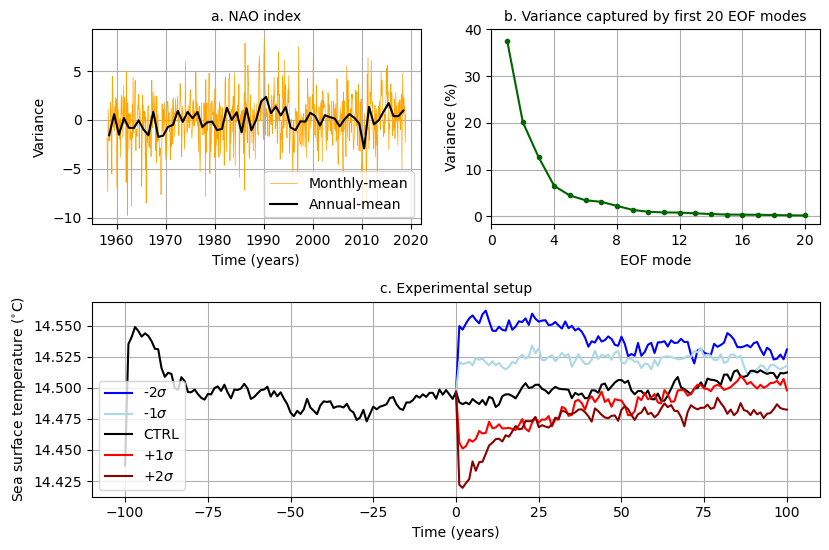

In [50]:
PC1_std = solver_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0)
PC1_var = solver_SLP.varianceFraction(neigs = 20) * 100
#fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6 * 1.5, 2 * 1.5))
fig = plt.figure()
fig.set_figheight(4 * 1.4)
fig.set_figwidth(6 * 1.4)

ax1 = plt.subplot2grid(shape = (2, 2), loc = (0, 0), rowspan = 1, colspan = 1)

(PC1_std/(PC1_std.coarsen(time = 12).mean().std())).plot(ax = ax1, color = 'orange', lw = 0.5, label = 'Monthly-mean')
(PC1_std.coarsen(time = 12).mean()/(PC1_std.coarsen(time = 12).mean().std())).plot(ax = ax1, color = 'black', label = 'Annual-mean')
ax1.set_title('a. NAO index', fontsize = 10)
ax1.set_ylabel('Variance')
ax1.set_xlabel('Time (years)')
ax1.grid()
ax1.legend()

ax1 = plt.subplot2grid(shape = (2, 2), loc = (0, 1), rowspan = 1, colspan = 1)

PC1_var.plot(ax = ax1, marker = 'o', markersize = 3, color = 'darkgreen')
ax1.set_title('b. Variance captured by first 20 EOF modes', fontsize = 10)
ax1.set_ylabel('Variance (%)')
ax1.set_xlabel('EOF mode')
ax1.set_yticks([0, 10, 20, 30, 40]);
ax1.set_xticks([-1, 3, 7, 11, 15, 19]);
ax1.set_xticklabels([0, 4, 8, 12, 16, 20])
ax1.grid()

ax1 = plt.subplot2grid(shape = (2, 2), loc = (1, 0), rowspan = 1, colspan = 2)

area = cc.querying.getvar('mom6-om4-025-RYF-control', 'areacello', session, frequency = 'static', n = 1)

SST_CTRL = cc.querying.getvar(expt[2], 'tos', session, frequency = '1 yearly', start_time = '1900-01-01', 
                         end_time = '2100-12-31', chunks = {})
SST_CTRL = SST_CTRL.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
area_NA = area.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
SST_CTRL = ((SST_CTRL * area_NA).sum(['xh', 'yh']))/(area_NA.sum(['xh', 'yh']))

for i, expt_name in enumerate(expt):
    if(expt_name == 'mom6-om4-025-RYF-control'):
        SST = cc.querying.getvar(expt_name, 'tos', session, frequency = '1 yearly', start_time = '1900-01-01', 
                         end_time = '2100-12-31', chunks = {})
    else:
        SST = cc.querying.getvar(expt_name, 'tos', session, frequency = '1 yearly', start_time = '2001-01-01', 
                         end_time = '2100-12-31', chunks = {})

    SST_NA = SST.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
    SST_avg = ((SST_NA * area_NA).sum(['xh', 'yh']))/(area_NA.sum(['xh', 'yh']))
    #SST_avg = ((SST * area).sum(['xh', 'yh']))/(area.sum(['xh', 'yh']))
    if(expt_name == 'mom6-om4-025-RYF-control'):
        ax1.plot(np.linspace(-100, 100, 201), SST_avg, label = expt_labels[i], color = color_values[i])
    else:
        ax1.plot(np.linspace(0, 100, 101), xr.concat([SST_CTRL.sel(time = slice('2000-01-01', '2000-12-31')), SST_avg], dim = 'time'), label = expt_labels[i], color = color_values[i])

ax1.set_title('c. Experimental setup', fontsize = 10)
ax1.set_ylabel('Sea surface temperature ($^{\circ}$C)')
ax1.set_xlabel('Time (years)')
ax1.grid()
ax1.legend()

plt.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Expt_setup.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

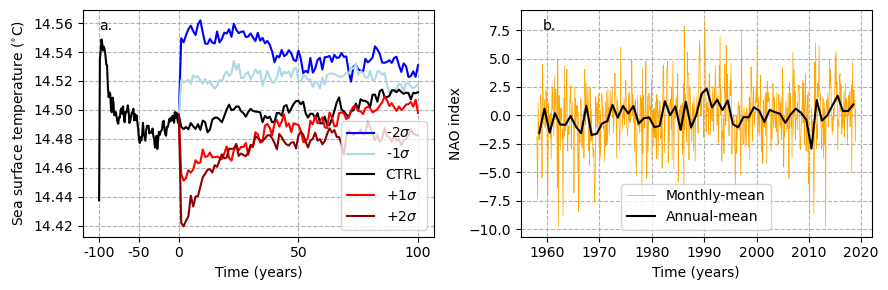

In [21]:
PC1_std = solver_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0)
PC1_var = solver_SLP.varianceFraction(neigs = 20) * 100

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6 * 1.5, 2 * 1.5))

(PC1_std/(PC1_std.coarsen(time = 12).mean().std())).plot(ax = axes[1], color = 'orange', lw = 0.5, label = 'Monthly-mean')
(PC1_std.coarsen(time = 12).mean()/(PC1_std.coarsen(time = 12).mean().std())).plot(ax = axes[1], color = 'black', label = 'Annual-mean')

#axes[1].set_title('b. NAO index', fontsize = 10)
axes[1].text(-3960, 7.5, 'b.', fontsize = 10)
axes[1].set_title('', fontsize = 10)
axes[1].set_ylabel('NAO index')
axes[1].set_xlabel('Time (years)')
axes[1].grid(True,ls = '--')
axes[1].legend()

area = cc.querying.getvar('mom6-om4-025-RYF-control', 'areacello', session, frequency = 'static', n = 1)

SST_CTRL = cc.querying.getvar(expt[2], 'tos', session, frequency = '1 yearly', start_time = '1900-01-01', 
                         end_time = '2100-12-31', chunks = {})
SST_CTRL = SST_CTRL.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
area_NA = area.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
SST_CTRL = ((SST_CTRL * area_NA).sum(['xh', 'yh']))/(area_NA.sum(['xh', 'yh']))

# Define a custom transformation function for the x-axis
def custom_x_transform(x):
    if x < 0:
        return x / 2  # Compress the negative range
    else:
        return x * 1.5  # Stretch the positive range

# Apply the custom transformation to the x-axis values
x_values = np.linspace(-100, 100, 201)
x_transformed = np.array([custom_x_transform(x) for x in x_values])

# Plotting the data
for i, expt_name in enumerate(expt):
    if expt_name == 'mom6-om4-025-RYF-control':
        SST = cc.querying.getvar(expt_name, 'tos', session, frequency='1 yearly', start_time='1900-01-01', 
                                 end_time='2100-12-31', chunks={})
    else:
        SST = cc.querying.getvar(expt_name, 'tos', session, frequency='1 yearly', start_time='2001-01-01', 
                                 end_time='2100-12-31', chunks={})

    SST_NA = SST.sel(xh=slice(x_min, x_max)).sel(yh=slice(y_min, y_max))
    SST_avg = ((SST_NA * area_NA).sum(['xh', 'yh'])) / (area_NA.sum(['xh', 'yh']))
    
    if expt_name == 'mom6-om4-025-RYF-control':
        axes[0].plot(x_transformed, SST_avg, label=expt_labels[i], color=color_values[i])
    else:
        axes[0].plot(x_transformed[100:], xr.concat([SST_CTRL.sel(time=slice('2000-01-01', '2000-12-31')), SST_avg], dim='time'), 
                     label=expt_labels[i], color=color_values[i])

# Generate xticks in the transformed space and corresponding labels
xticks_transformed = np.array([custom_x_transform(x) for x in np.linspace(-100, 100, 5)])
xtick_labels = np.linspace(-100, 100, 5)

# Set axis labels and titles as before
#axes[0].set_title('a. Experimental setup', fontsize=10)
axes[0].text(-50, 14.555, 'a.', fontsize = 10)
axes[0].set_title('', fontsize=10)
axes[0].set_ylabel('Sea surface temperature ($^{\circ}$C)')
axes[0].set_xlabel('Time (years)')
axes[0].grid(True, ls = '--')
axes[0].legend()
axes[0].set_xticks(xticks_transformed)
axes[0].set_xticklabels([f'{int(label)}' for label in xtick_labels])

plt.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Expt_setup.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

## Correlations

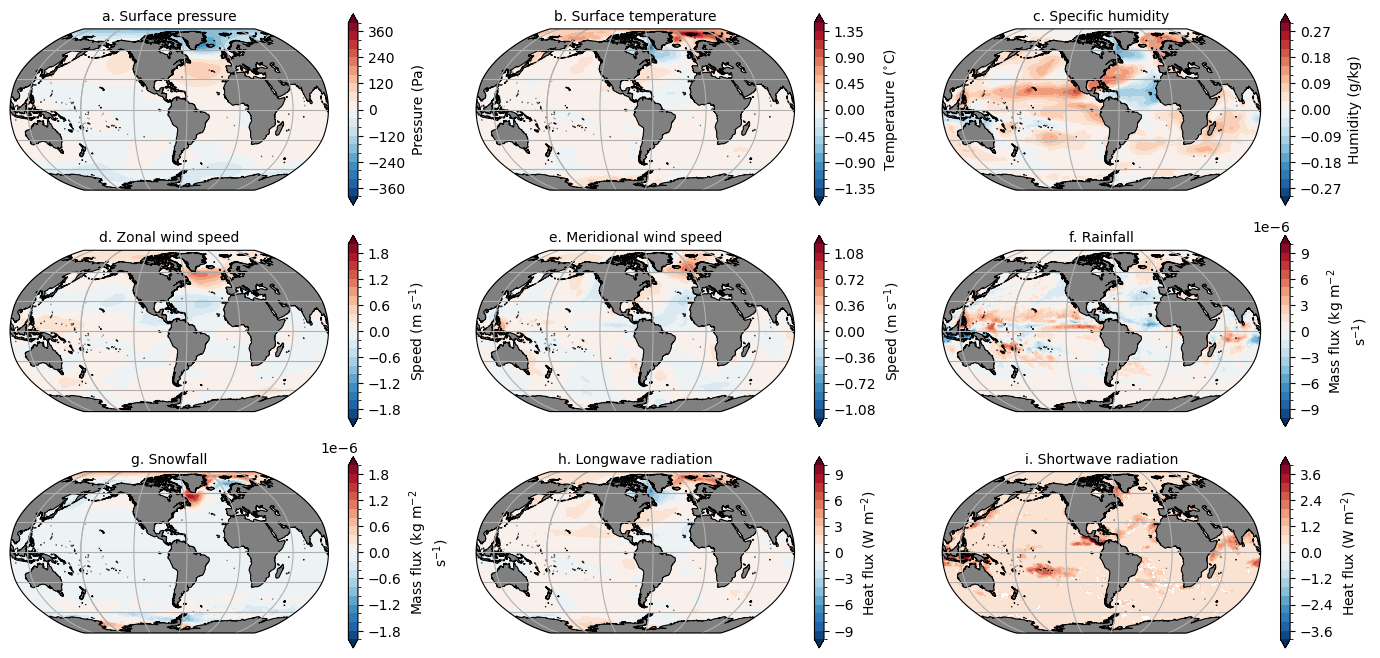

In [17]:
fig = plt.figure()
fig.set_figheight(4.8 * 1.4)
fig.set_figwidth(10 * 1.4)

var_series = ['psl', 'tas', 'huss', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']#, 'friver', 'licalvf']
limits     = [400,   1.5,   0.3,   2,     1.2,   1e-5,   2e-6,   10,     4]#,       1e-16,       1e-16]
label_series = ['a. Surface pressure', 'b. Surface temperature', 'c. Specific humidity', 
                'd. Zonal wind speed', 'e. Meridional wind speed', 'f. Rainfall', 
                'g. Snowfall', 'h. Longwave radiation', 'i. Shortwave radiation']#, 'Runoff', 'Calving']
label_series_cb = ['Pressure (Pa)', 'Temperature ($^{\circ}$C)', 'Humidity (g/kg)', 
                   'Speed (m s$^{-1}$)', 'Speed (m s$^{-1}$)', 'Mass flux (kg m$^{-2}$ s$^{-1}$)',
                   'Mass flux (kg m$^{-2}$ s$^{-1}$)', 'Heat flux (W m$^{-2}$)', 'Heat flux (W m$^{-2}$)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)

for i, j in enumerate(var_series):
    var_forcing_input = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_mean_forcing_variables_JRA55_v1_4/' + j + '_raw.nc')[j]

    ## Changing specific humidity to g/kg
    if(i == 2):
        var_forcing_input = var_forcing_input * 1000

    b = var_forcing_input.coarsen(time = 12).mean()
    b['time'] = NAO_index_all_months.time
    regression = ((NAO_index_all_months - NAO_index_all_months.mean('time'))*(b - b.mean('time'))/NAO_index_all_months.std('time')).mean('time')
    regression = regression.rename(label_series_cb[i])
    ax1 = plt.subplot2grid(shape = (3, 3), loc = (int(i/3), int(i%3)), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
    ax1.coastlines(resolution = '50m')
    ax1.add_feature(land_50m)
    gl = ax1.gridlines(draw_labels = False)

    p1 = regression.plot.contourf(ax = ax1, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-limits[i], limits[i], 21),
                                   add_colorbar = True, rasterized = True, zorder = -20, extend = 'both')
    ax1.set_title(label_series[i], fontsize = 10)

plt.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Regression_NAO_variables.jpg', bbox_inches = 'tight', 
            dpi = 300, transparent=True)